In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

import nltk; nltk.download('stopwords')

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models 
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/huiwen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [3]:
# Read data
tweets = pd.read_csv('/Users/huiwen/Documents/Side Projects/Omdena/SG Covid-19 NLP/omdena-singapore-covid-health/src/data/twitter/cleaned/final_clean_data.csv')
tweets.head()

,Unnamed: 0,date,hashtags,username,nlikes,nreplies,nretweets,search,clean_tweet4,year,month
0,1,2019-12-29 13:54:00,[],JesusDailyTwits,1,0,0,depression,best depression killer worshipping jesus try v...,2019,12
1,2,2019-12-29 12:47:00,[],Aluvrendar,67,3,6,depression,hope blessings majlis depression never return ...,2019,12
2,3,2019-12-29 12:33:00,[],mengwong,0,2,0,depression,feels like theory psychohistory ing together h...,2019,12
3,4,2019-12-28 18:33:00,[],haziqqqaaahzik,10,1,8,depression,post project depression cant believe days ende...,2019,12
4,8,2019-12-26 02:16:00,[],NASYRANN_,0,1,3,depression,depression thought,2019,12


In [4]:
# Tokenize words and further clean-up text
# Tokenize each sentence into list of words

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
#         print(sentence)

data = tweets.clean_tweet4.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:2])

[['best', 'depression', 'killer', 'worshipping', 'jesus', 'try', 'viayoutube'], ['hope', 'blessings', 'majlis', 'depression', 'never', 'return', 'anxiety', 'panic', 'attacks', 'pletely', 'disappear', 'hope', 'heal']]


### Bigram and Trigram Models

In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [6]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [7]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, verb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:2])

[['good', 'depression', 'killer', 'worship', 'try', 'viayoutube'], ['hope', 'blessing', 'majli', 'depression', 'never', 'return', 'anxiety', 'panic_attack', 'pletely', 'disappear', 'hope', 'heal']]


### Date Transformation -  Corpus for needed for Topic Modelling

In [8]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:2])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)], [(0, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)]]


In [9]:
id2word[0]
# corpus[:1][0][:10]

'depression'

In [10]:
# Readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('depression', 1),
  ('good', 1),
  ('killer', 1),
  ('try', 1),
  ('viayoutube', 1),
  ('worship', 1)]]

### Building Topic Model

In [12]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [13]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.045*"talk" + 0.035*"news" + 0.027*"miss" + 0.025*"include" + '
  '0.025*"state" + 0.021*"walk" + 0.018*"especially" + 0.016*"mind" + '
  '0.016*"nurse" + 0.016*"available"'),
 (1,
  '0.041*"good" + 0.030*"year" + 0.025*"world" + 0.024*"let" + 0.023*"way" + '
  '0.020*"many" + 0.019*"health" + 0.018*"virus" + 0.017*"great" + '
  '0.014*"already"'),
 (2,
  '0.029*"get" + 0.024*"go" + 0.019*"vaccine" + 0.018*"people" + 0.018*"day" + '
  '0.016*"zoom" + 0.015*"time" + 0.015*"take" + 0.014*"need" + 0.013*"see"'),
 (3,
  '0.048*"make" + 0.039*"work" + 0.027*"week" + 0.019*"last" + 0.017*"keep" + '
  '0.017*"try" + 0.016*"safe" + 0.014*"read" + 0.013*"due" + 0.012*"tell"'),
 (4,
  '0.081*"covid" + 0.049*"amp" + 0.031*"call" + 0.024*"life" + 0.022*"high" + '
  '0.021*"right" + 0.017*"place" + 0.017*"change" + 0.016*"point" + '
  '0.015*"leave"'),
 (5,
  '0.053*"give" + 0.033*"support" + 0.033*"government" + 0.026*"mean" + '
  '0.025*"wear" + 0.020*"school" + 0.018*"break" + 0.018*"in

### Compute Model Perplexity and Coherance Score

In [14]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is, lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.96781664278112

Coherence Score:  0.26323074914877553


### Visualise Topic Keywords

In [15]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.284236 -0.306842       1        1  37.883932
6      0.154390  0.171308       2        1  13.132316
3      0.100414  0.099711       3        1  10.026984
1      0.079498  0.142202       4        1   9.548883
9      0.104358  0.006427       5        1   8.939167
4     -0.036990  0.115416       6        1   7.467313
5     -0.150929 -0.047571       7        1   4.565911
7     -0.126386 -0.013364       8        1   4.517815
0     -0.204845 -0.087376       9        1   2.818007
8     -0.203746 -0.079910      10        1   1.099672, topic_info=               Term         Freq        Total Category  logprob  loglift
13356        spread  6081.000000  6081.000000  Default  30.0000  30.0000
2447           mask  4357.000000  4357.000000  Default  29.0000  29.0000
15908         covid  3904.000000  3904.000000  Default  28.0000  28.0000
167            make  3101.000000  3101.000000  Default  27.0000  27.0000
94              get  7076.000000  7076.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
2969         engage    52.575116    53.489504  Topic10  -4.9004   4.4929
5312      implement    45.577406    46.491848  Topic10  -5.0432   4.4903
756       fantastic    45.572996    46.487543  Topic10  -5.0433   4.4903
8723       telegram    45.414444    46.333030  Topic10  -5.0468   4.4901
5153   contribution    44.841924    45.756988  Topic10  -5.0595   4.4900

[350 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
828       3  0.997340      able
1687      9  0.994335   account
3568     10  0.994897    action
233       4  0.997965  actually
612       6  0.997084     agree
...     ...       ...       ...
9727      4  0.019072      zoom
9727      5  0.030992      zoom
9727      6  0.008669      zoom
9727      7  0.001951      zoom
9727      8  0.006502      zoom

[353 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 4, 2, 10, 5, 6, 8, 1, 9])

/Users/huiwen/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/huiwen/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/huiwen/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/huiwen/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


### Building LDA Mallet Model

In [ ]:
# !curl http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip — output mallet-2.0.8.zip
# !unzip mallet-2.0.8.zip

In [18]:
## Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/Users/huiwen/Downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word) # latest gensim not supported, use 3.8.3

Mallet LDA: 10 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 35
total tokens: 533034
<10> LL/token: -10.41306
<20> LL/token: -10.16998
<30> LL/token: -10.01573
<40> LL/token: -9.90153

0	5	tired week work fight stress today day time amp back spread run mask singapore stay lockdown thing leave month dead 
1	5	tired fight people covid health stay home world stop pandemic hospital test project time feel work day system thing happy 
2	5	tired fight people feel dead day vaccine government time thing stress emotion make good hard hurt guy lockdown order control 
3	5	testing people tired death case day feel call zoom amp good face put pandemic toxic vaccine coronavirus dead high love 
4	5	dead good mask time walk fight make amp wait people book hospital hope tired day pandemic stress gon long thing 
5	5	death tired dead support amp stress time give toxic make good food post pandemic abuse people place read live share 
6	5	covid feel time day work make people home tired love q

<310> LL/token: -8.88373
<320> LL/token: -8.87758
<330> LL/token: -8.87299
<340> LL/token: -8.86593

0	5	tired work today back feel week sleep start fuck run fucking shit hour phase gon long morning early rest sick 
1	5	drug big check health issue business point problem woman crisis level send hold state group ppl patient future system protect 
2	5	make thing people feel emotion bad stop talk guy happen lonely man heart die life show money hate hear cry 
3	5	death covid vaccine case country coronavirus test testing high travel virus number government munity news people low report receive risk 
4	5	dead stress mask face wait lol put buy night break kid long finally walk damn wear man book head omg 
5	5	amp people pandemic toxic world live support read share word understand abuse story crisis plan reason join post power lead 
6	5	hospital home lockdown friend hope singapore stay time care family month food year bring due place close leave child pay 
7	5	day spread good quarantine watch t

<610> LL/token: -8.79946
<620> LL/token: -8.80007
<630> LL/token: -8.80021
<640> LL/token: -8.79645

0	5	tired work back week today feel start sleep fuck fucking run gon long shit hour morning early rest sick late 
1	5	drug big health check issue business problem woman part group small fast hold patient system grow deal government focus protect 
2	5	people make thing feel emotion bad stop man talk happen lonely die life show heart money hate hear kill point 
3	5	death covid vaccine case country coronavirus test testing high travel virus number munity news low report government receive risk update 
4	5	dead stress mask face wait put lol buy guy time night body kid walk finally wear send head book break 
5	5	amp pandemic world live support change read crisis share word understand abuse story therapy post plan people reason join power 
6	5	time hospital home year lockdown friend hope singapore stay month care family leave food bring due mental_health close place happy 
7	5	day spread quar

<910> LL/token: -8.77653
<920> LL/token: -8.77387
<930> LL/token: -8.77191
<940> LL/token: -8.77221

0	5	tired work back feel week today sleep fuck run fucking gon start shit hour long morning early rest sick damn 
1	5	drug big health check issue business problem woman group set small fast manage reach deal patient system grow build protect 
2	5	people make thing feel life emotion man bad stop talk happen person die lonely show heart money hate hear point 
3	5	death covid vaccine case country coronavirus test testing high virus number government munity news level low report state receive risk 
4	5	dead stress mask face wait put lol buy night body kid walk wear head finally break remember baby send omg 
5	5	amp pandemic world live crisis support change read share word post understand abuse story future join part power lead important 
6	5	time home year hospital lockdown friend hope singapore stay month care family food place leave bring due mental_health travel close 
7	5	day spread qua

In [19]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('tired', 0.12359867579565119),
   ('work', 0.055695583477541194),
   ('back', 0.03398916560078248),
   ('week', 0.026333609209239335),
   ('feel', 0.025750507862463322),
   ('sleep', 0.01822661951696637),
   ('today', 0.016383266872319616),
   ('fuck', 0.015743736362952374),
   ('run', 0.014408246181626665),
   ('fucking', 0.014389436460762923)]),
 (1,
  [('drug', 0.014799821733640348),
   ('big', 0.013369976973928544),
   ('health', 0.011828715739434004),
   ('check', 0.011605882789868528),
   ('issue', 0.010863106291316942),
   ('business', 0.009581816831315457),
   ('woman', 0.008467652083488078),
   ('problem', 0.008467652083488078),
   ('group', 0.007074946148703855),
   ('fast', 0.0066292802495729036)]),
 (2,
  [('people', 0.07489513577157995),
   ('make', 0.05392229008757083),
   ('thing', 0.03484435940834499),
   ('feel', 0.028202958275075428),
   ('life', 0.024817867392744133),
   ('emotion', 0.023346088748252263),
   ('man', 0.019703436603134887),
   ('bad', 0.019427

### Finding Optimal Number of topics for LDA

In [23]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [24]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

Mallet LDA: 2 topics, 1 topic bits, 1 topic mask
Data loaded.
max tokens: 35
total tokens: 533034
<10> LL/token: -9.17652
<20> LL/token: -9.11507
<30> LL/token: -9.07524
<40> LL/token: -9.04489

0	25	tired day fight time dead amp work people good love death home back feel vaccine make today start spread mask 
1	25	fight tired people make time covid day stress feel pandemic life good dead work death give mask thing year watch 

<50> LL/token: -9.01722
<60> LL/token: -8.99571
<70> LL/token: -8.97144
<80> LL/token: -8.94999
<90> LL/token: -8.93421

0	25	tired day fight dead time work amp love good home back feel today people hospital start spread make death week 
1	25	people make covid fight stress pandemic time death mask feel good life vaccine day year give world thing watch singapore 

<100> LL/token: -8.91192
<110> LL/token: -8.88861
<120> LL/token: -8.86691
<130> LL/token: -8.8465
<140> LL/token: -8.82654

0	25	tired day fight dead time work feel amp love good today back home make ho

<60> LL/token: -9.64428
<70> LL/token: -9.58097
<80> LL/token: -9.51655
<90> LL/token: -9.45813

0	6.25	dead day singapore stress start hospital work covid year life today people make death due team story week love news 
1	6.25	day home stay dead circuit_breaker time back week end quarantine phase month year travel work love leave start read make 
2	6.25	case death fight make crisis covid tired watch government back dead kill woman problem lot number walk bad die people 
3	6.25	work zoom amp people lockdown fight thing pandemic time hospital family day video good world create great wear system part 
4	6.25	people testing test good sleep bring fight money stress toxic spread eat circuitbreaker drug place free word make thing buy 
5	6.25	fight mask good give face death feel stress call tired make man dead people super world lose learn show stand 
6	6.25	tired vaccine feel today fuck time fucking run find sick coronavirus people shit gon wait amp love night wanna happen 
7	6.25	amp spread

<460> LL/token: -8.81035
<470> LL/token: -8.80907
<480> LL/token: -8.80685
<490> LL/token: -8.80619

0	6.25	covid pandemic world change read due team job learn business great story news human happen student idea manage risk top 
1	6.25	day work time back home today start year week end lockdown quarantine stay long month circuit_breaker coronavirus phase travel family 
2	6.25	people death case crisis stop play country die government bad virus game issue real number dead abuse problem continue woman 
3	6.25	thing time hospital friend make call find zoom post place part video send big create matter move group easy important 
4	6.25	spread test testing drug food free eat singapore make good open buy money great pay follow therapy set pm order 
5	6.25	fight love mask good give man watch face guy make show talk put lose hard happy hate wear remember hand 
6	6.25	tired feel dead stress vaccine sleep fuck wait fucking run gon shit lol lonely hour night body sick rest damn 
7	6.25	amp life emot

<860> LL/token: -8.76101
<870> LL/token: -8.7614
<880> LL/token: -8.75899
<890> LL/token: -8.7568

0	6.25	covid pandemic coronavirus change read due team job world business understand story high news human create student idea manage risk 
1	6.25	day work back home year today week start lockdown end quarantine stay long month circuit_breaker time wait run phase travel 
2	6.25	people death case country stop bad die government virus crisis issue abuse number problem kill real reason control power low 
3	6.25	time thing make hospital friend find call zoom family happen world big part post place lot video move send matter 
4	6.25	spread test testing drug food free eat great singapore buy open money walk pay follow therapy set make online pm 
5	6.25	fight love mask good man watch face give guy talk show put hard play lose make kid hate wear remember 
6	6.25	tired dead feel stress vaccine sleep fuck fucking gon leave lol lonely shit hour night body rest sick damn early 
7	6.25	amp life toxic 

<160> LL/token: -9.18173
<170> LL/token: -9.15388
<180> LL/token: -9.12906
<190> LL/token: -9.10645

0	3.57143	hospital dead end love show care make hope good death watch happy hour matter thing true patient small movie lie 
1	3.57143	vaccine month dead child game find set turn buy time receive risk shoot read sell drop crazy drive start report 
2	3.57143	man fight guy test fuck testing give drug fucking issue abuse woman find shit cry power depression girl break dead 
3	3.57143	fight time good quarantine great family team watch play big finally miss win nice weekend friend step amazing house lol 
4	3.57143	talk call lose people understand mental_health experience story munity live toxic share point pay read build social_distance fight learn bring 
5	3.57143	tired feel today sleep week run lonely gon night time walk late early wake long sad morning wanna day tomorrow 
6	3.57143	world high change business make close plan level create future class public event grow study idea global part

<410> LL/token: -8.8981
<420> LL/token: -8.89493
<430> LL/token: -8.88879
<440> LL/token: -8.88358

0	3.57143	dead hospital end show leave care hope heart make give remember matter small true patient movie hear lie boy treat 
1	3.57143	vaccine find month child turn set report receive question risk shoot drop drive sell imagine parent sign crazy music note 
2	3.57143	give man guy test fuck testing drug fucking break issue abuse dead woman cry shit power depression girl fight damn 
3	3.57143	fight good quarantine great watch family play time big friend team game miss win nice pretty weekend spend house amazing 
4	3.57143	live talk lose read mental_health understand video mind story experience friend learn bring share join social_distance call part fan build 
5	3.57143	tired feel today sleep run gon lonely night morning lol early sick walk late head sad wake wanna super tomorrow 
6	3.57143	world crisis high business change pay plan level create future important part student event public g

<660> LL/token: -8.8392
<670> LL/token: -8.83922
<680> LL/token: -8.83471
<690> LL/token: -8.83734

0	3.57143	dead hospital end leave show hope heart care head bring true patient movie lie remember brain boy treat hear drink 
1	3.57143	vaccine month find check child turn set report receive reach question risk parent shoot drop imagine sell note sign result 
2	3.57143	give man guy fuck testing test drug fucking issue abuse woman kill cry shit power depression girl fine pass stupid 
3	3.57143	fight good quarantine watch great family play big team game miss friend nice win time pretty house amazing catch room 
4	3.57143	talk friend lose read mental_health share understand mind part story social_distance experience learn live care join video point twitter step 
5	3.57143	tired feel today sleep run gon lol lonely night morning early sick walk damn late sad wake super wanna tomorrow 
6	3.57143	crisis business world pay high level create future lead change student event important grow build s

<910> LL/token: -8.82198
<920> LL/token: -8.82487
<930> LL/token: -8.82174
<940> LL/token: -8.81912

0	3.57143	dead hospital leave show end heart hope head remember death house hear true lie room brain boy treat walk drink 
1	3.57143	vaccine find month child set turn receive question reach parent shoot note sell result sign variant drive include crazy music 
2	3.57143	give man guy test fuck testing drug fucking issue abuse shit woman kill cry power depression girl fine pass stupid 
3	3.57143	fight good watch great family play big team game miss video win pretty amazing catch nice song top movie finish 
4	3.57143	friend talk read lose care share bring make mental_health understand mind part story experience learn listen twitter fan munity young 
5	3.57143	tired feel today sleep run gon lol lonely hour night morning early sick damn sad guess wake super wanna omg 
6	3.57143	crisis business pay world create change future join lead important student event build study global focus base marke

<110> LL/token: -9.46555
<120> LL/token: -9.40716
<130> LL/token: -9.35629
<140> LL/token: -9.31143

0	2.5	amp call free therapy online child student class hit daily market study art record session important price medium process infect 
1	2.5	stress time fight run work today stop life long amazing break start talk give miss people stand club trap race 
2	2.5	covid vaccine hospital case country munity news number report receive patient due doctor vaccination datum infection health staff link rate 
3	2.5	day tired back week sleep happy care night feel wake baby miss anymore late early post lunch healthy smile date 
4	2.5	feel tired lonely dead heart make life good friend time wanna fine song man pray kind yesterday beautiful music sick 
5	2.5	good amp spread make great movie screen cut add money cluster min simple vote include time side serve create tonight 
6	2.5	coronavirus safe business government continue measure question service spread local expect part visit chance current effort s

<260> LL/token: -9.062
<270> LL/token: -9.05285
<280> LL/token: -9.04705
<290> LL/token: -9.03941

0	2.5	amp call free therapy online hit class student important study daily hold market art session suicide medium price release drop 
1	2.5	time stress long work stop run today break start amazing action finish give trap bit hard entire hear race back 
2	2.5	covid vaccine hospital case number munity due country report news receive patient doctor vaccination rise datum infection record symptom staff 
3	2.5	day tired back work week sleep wait happy post miss early night late wake baby finally anymore brain lunch smile 
4	2.5	feel make good lonely heart rest friend life wanna fine song listen pretty sick boy beautiful pray music happy everyday 
5	2.5	good make great spread screen movie easy side cut sell add min cluster simple half moment share today serve hot 
6	2.5	support coronavirus government team safe business continue part measure service reach question expect local sign visit custome

<410> LL/token: -8.98143
<420> LL/token: -8.97906
<430> LL/token: -8.97324
<440> LL/token: -8.97209

0	2.5	amp free buy therapy online student class find study join important daily market level session art drop price medium release 
1	2.5	time stress long work today stop run break start hard hope hear bit enjoy amazing worry good trap action hit 
2	2.5	covid vaccine hospital case number due news munity report receive patient vaccination doctor update datum infection record symptom rise medical 
3	2.5	tired day work back week sleep wait post early miss rest night late wake finally happy super baby brain bed 
4	2.5	feel make good lonely happy sad life feeling wanna listen heart song boy fine beautiful pretty everyday music cover happen 
5	2.5	good spread great make screen movie fan side sell cut lunch add min cluster easy simple half short hot piece 
6	2.5	support team government safe business part continue coronavirus measure service reach visit question local sign state expect customer

<560> LL/token: -8.94914
<570> LL/token: -8.94103
<580> LL/token: -8.9434
<590> LL/token: -8.93888

0	2.5	amp free buy find therapy online join class study daily market art session level price release student product huge store 
1	2.5	time stress long run hope hard work today start break good hear hit bit give worry back trap enjoy race 
2	2.5	covid vaccine hospital case due number news munity report receive patient update vaccination doctor rise datum infection record symptom virus 
3	2.5	day work tired back week sleep wait post miss early rest finally night late wake super baby fun happy bed 
4	2.5	feel make happy lonely good sad heart feeling life wanna listen moment fine song boy give beautiful pray smile music 
5	2.5	good great spread make screen movie fan side idea sell pretty cut half addiction line add min easy cluster simple 
6	2.5	support government team safe business continue coronavirus part measure situation visit place service reach local sign current group state leader 


<710> LL/token: -8.92478
<720> LL/token: -8.92055
<730> LL/token: -8.92211
<740> LL/token: -8.9215

0	2.5	amp free buy find therapy online share join class level study student daily market art session price product release store 
1	2.5	time stress long work run hard start give hope break today good hit bit big enjoy worry hear trap short 
2	2.5	covid vaccine hospital case due number munity news report receive patient update doctor vaccination datum infection record virus health medical 
3	2.5	day work week back sleep wait hour miss early finally rest night morning tired late wake super baby post spend 
4	2.5	feel make happy lonely good sad life feeling wanna heart listen moment song remember beautiful smile music everyday boy happen 
5	2.5	good great spread make pretty screen idea movie fan easy side sell nice cut variant half add line light addiction 
6	2.5	support coronavirus government team safe business continue part situation measure visit service reach sign current place customer

<860> LL/token: -8.90688
<870> LL/token: -8.90602
<880> LL/token: -8.90537
<890> LL/token: -8.90454

0	2.5	amp free buy therapy find online pm join share level class study market student art session price release product store 
1	2.5	time stress long today run give hard big hope work break good start hit bit enjoy worry trap race slow 
2	2.5	covid vaccine hospital case number due news munity report receive patient update vaccination doctor virus datum infection record symptom medical 
3	2.5	day work back week sleep wait hour night miss morning early rest late wake super baby post tired yesterday spend 
4	2.5	feel make happy lonely emotion sad heart feeling good wanna listen moment song pray beautiful smile music special sound remember 
5	2.5	good great watch spread idea pretty screen amazing side movie fan light sell variant line nice addiction add make cut 
6	2.5	coronavirus support government team safe business part situation continue measure group service reach visit sign provide cu

Mallet LDA: 26 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 35
total tokens: 533034
<10> LL/token: -11.05121
<20> LL/token: -10.68469
<30> LL/token: -10.46152
<40> LL/token: -10.28955

0	1.92308	make covid work toxic time stupid mental_health pandemic fight coronavirus social_distance abuse good feel tomorrow week man digital woman red 
1	1.92308	people vaccine news stand covid business shoot birthday deal medium local protect term twitter sale feel fight toxic give social 
2	1.92308	government time amp good day people drug care pandemic year poor video mind circuit_breaker open death phone fight happy fine 
3	1.92308	day dead tired circuit_breaker people therapy skin black back time read buy good stress week lunch guy friend happen bad 
4	1.92308	death vaccine coronavirus tired stress fight dead long cat market make job pany super challenge day people panie real photo 
5	1.92308	people covid change travel pandemic art world zoom crisis fight infect hospital class to

<160> LL/token: -9.28988
<170> LL/token: -9.26378
<180> LL/token: -9.23378
<190> LL/token: -9.21631

0	1.92308	stop play fuck mental_health people give toxic issue ppl tomorrow care pass stupid make honestly spread message send public wear_mask 
1	1.92308	people spread coronavirus covid country world news problem shoot protect stand datum affect govt fast term medium disease indian truth 
2	1.92308	drug crisis government pay money abuse video fine state people plan small focus social mind health poor economy worker police 
3	1.92308	day circuit_breaker today therapy amazing fun lunch baby dinner beautiful black special simple birthday spend ago shn pic skin awesome 
4	1.92308	vaccine give hospital die death super post show photo doctor real deserve pany world trust tweet uncertainty cat dose question 
5	1.92308	pandemic zoom learn travel health world covid class system lead change art online team future infect response staff member digital 
6	1.92308	home quarantine stay read long open

<310> LL/token: -9.08662
<320> LL/token: -9.0833
<330> LL/token: -9.07728
<340> LL/token: -9.07602

0	1.92308	people toxic stop play give care mental_health make ppl spread pass stupid honestly message send issue tomorrow throw wear_mask respect 
1	1.92308	spread covid country world coronavirus news problem risk shoot return protect datum chinese affect govt people fire develop force term 
2	1.92308	drug government crisis abuse pay health issue power state money fine social public act poor economy worker police handle official 
3	1.92308	day circuit_breaker baby fun amazing today lunch dinner beautiful special black simple top cook meal awesome end pic shn kick 
4	1.92308	vaccine give die post super receive photo doctor show tweet trust death pany deserve cat dose interesting uncertainty slow vaccinate 
5	1.92308	pandemic zoom learn team change lead class future situation system art health world staff opportunity current online infect great response 
6	1.92308	home quarantine stay read

<460> LL/token: -9.02925
<470> LL/token: -9.02526
<480> LL/token: -9.02453
<490> LL/token: -9.01837

0	1.92308	people toxic stop care play mental_health give make ppl important fan honestly pass stupid glad respect focus law realise throw 
1	1.92308	spread world country coronavirus virus news problem risk shoot chinese affect force govt fire develop term indian disease remain datum 
2	1.92308	drug government abuse crisis issue health pay power fine public state social rule poor economy police fail worker party act 
3	1.92308	day circuit_breaker post fun lunch today dinner black amazing top special simple circuitbreaker delivery cook meal shn beautiful baby breakfast 
4	1.92308	vaccine give die death post receive photo vaccination show pany cat dose interesting slow trust type vaccinate challenge doctor claim 
5	1.92308	zoom pandemic learn team change situation lead class system great current art staff future meeting project teach response research infect 
6	1.92308	home quarantine stay

<610> LL/token: -8.99639
<620> LL/token: -8.9984
<630> LL/token: -8.99798
<640> LL/token: -9.0034

0	1.92308	people toxic stop care give play mental_health make important ppl issue stupid treat glad honestly fan effort mental focus deserve 
1	1.92308	spread world country virus coronavirus news problem risk shoot outbreak chinese govt fast result force fire develop handle term disease 
2	1.92308	drug government abuse crisis power health public issue pay fine social rule act poor state worker economy police fail party 
3	1.92308	day circuit_breaker post today lunch dinner black simple special delivery serve cook top meal shn pic decide circuitbreaker quick order 
4	1.92308	vaccine give covid post show die receive photo vaccination datum pany cat challenge dose type interesting turn vaccinate explain claim 
5	1.92308	zoom learn team pandemic change situation class lead system great project health current art staff experience future meeting improve infect 
6	1.92308	home quarantine stay re

<760> LL/token: -8.9791
<770> LL/token: -8.97965
<780> LL/token: -8.97502
<790> LL/token: -8.97999

0	1.92308	people toxic stop care give mental_health reason ppl important treat die stupid deserve relationship effort mental tweet blame focus matter 
1	1.92308	spread world country virus coronavirus news problem risk outbreak chinese fear govt follow shoot force fast fire term large disease 
2	1.92308	drug government abuse issue health power crisis public state support social act rule poor fine worker police party protect fail 
3	1.92308	day circuit_breaker food post lunch dinner today drink simple delivery serve circuitbreaker decide cook order meal shn pic favourite spread 
4	1.92308	vaccine give covid post show receive photo question vaccination datum cat die explain dose type vaccinate interesting answer challenge raise 
5	1.92308	zoom learn team great pandemic class system experience patient project health current art lead staff leader improve meeting situation teach 
6	1.92308	hom

<910> LL/token: -8.96545
<920> LL/token: -8.96474
<930> LL/token: -8.96222
<940> LL/token: -8.9601

0	1.92308	people toxic stop give care mental_health reason hate ppl treat stupid deserve relationship die issue important blame throw make choice 
1	1.92308	spread world country virus coronavirus news problem follow risk fast outbreak chinese fear shoot force fire term true large disease 
2	1.92308	drug government abuse power public issue health crisis support plan social rule govt act medium poor protect worker police party 
3	1.92308	day circuit_breaker food eat lunch order dinner circuitbreaker post drink simple delivery serve cook meal decide shn favourite prepare top 
4	1.92308	vaccine covid show post give receive photo question die vaccination explain cat dose datum vaccinate slow blood interesting require answer 
5	1.92308	zoom learn team great health class patient system project lead current art experience staff improve meeting teach important goal member 
6	1.92308	home quaranti

<60> LL/token: -10.09643
<70> LL/token: -9.96963
<80> LL/token: -9.85297
<90> LL/token: -9.74977

0	1.5625	stress work good zoom tired feel body thing life morning sign home beautiful wake exercise full sick deal bit workout 
1	1.5625	mask face good wear show buy number govt vote dose high week release charge meal episode control public election dear 
2	1.5625	travel place eat day visit phase food home test hotel isolation cat great delivery number doctor meet view make dog 
3	1.5625	testing end tired pandemic omg miss work session water handle zentrader tweet_full term_trend strategy_short reversal_beta read_pinne platform_zentrader info_forexsignal free_trade beat 
4	1.5625	circuitbreaker news period call check measure lockdown include note circuit_breaker variant return part level coronavirus stayhome cut sell set official 
5	1.5625	case school munity social_distance student stop vaccination local staff cluster practice current glad situation back study teacher area match round 
6	1

<160> LL/token: -9.33009
<170> LL/token: -9.30499
<180> LL/token: -9.28682
<190> LL/token: -9.25953

0	1.5625	stress work zoom good body full thing hard bit rest life deal prepare project training workout wake motivation posted_photo sis 
1	1.5625	mask face show buy wear phone good control free office vote govt release episode charge public election review fake apple 
2	1.5625	place food eat travel visit weekend room drink hotel isolation phase cat delivery centre serve couple view meal shn meet 
3	1.5625	testing end time miss pandemic omg video water listen dead date begin handle real make zentrader tweet_full term_trend strategy_short reversal_beta 
4	1.5625	lockdown call news circuitbreaker period measure number level include sell return daily variant check note enter stayhome official singapore circuit_breaker 
5	1.5625	school munity social_distance check bring student case close stop local understand back current area glad cluster add situation practice staff 
6	1.5625	coronavirus

<260> LL/token: -9.16408
<270> LL/token: -9.15955
<280> LL/token: -9.15423
<290> LL/token: -9.14613

0	1.5625	stress work zoom hard rest good bit body full fun exercise easily workout training imagine motivation posted_photo sis thing busy 
1	1.5625	mask face buy put wear control show phone public govt vote episode charge pull match election review activity fake cover 
2	1.5625	place food eat travel visit room drink hotel order isolation weekend cat delivery serve good centre coffee meal shn option 
3	1.5625	time testing end pandemic miss video omg show listen water wait date begin handle zentrader tweet_full term_trend strategy_short reversal_beta read_pinne 
4	1.5625	lockdown period news call measure circuitbreaker singapore circuit_breaker include return daily variant level sell stayhome late extend official plan clear 
5	1.5625	bring check school munity social_distance student close important move situation understand add area list current practice back full cluster glad 
6	1.5625	

<360> LL/token: -9.09064
<370> LL/token: -9.08969
<380> LL/token: -9.08404
<390> LL/token: -9.07908

0	1.5625	work stress zoom hard rest body bit full exercise busy fun easily training ready workout colleague motivation posted_photo sis hahahaha 
1	1.5625	mask face put buy wear phone govt black vote cover sell charge activity pull public fake stock match election box 
2	1.5625	place food eat travel order visit room drink good hotel weekend isolation cat pretty serve centre delivery coffee meal shn 
3	1.5625	time end testing show pandemic miss video omg listen class water date handle begin wait zentrader tweet_full term_trend strategy_short reversal_beta 
4	1.5625	lockdown singapore period news circuit_breaker measure circuitbreaker sgunite daily variant return open clear stayhome lock part plan extend include enter 
5	1.5625	bring check school close social_distance move student back add due important understand full area list practice glad difficult situation teacher 
6	1.5625	coronavi

<460> LL/token: -9.06526
<470> LL/token: -9.05944
<480> LL/token: -9.0519
<490> LL/token: -9.0483

0	1.5625	work stress zoom hard rest bit body exercise fun colleague training workout easily busy full motivation posted_photo sis hahahaha ing 
1	1.5625	mask face put buy wear black govt cover water vote sell charge election review fake stock remember white box bag 
2	1.5625	food place eat travel order visit weekend room drink hotel isolation cat prepare delivery view serve centre coffee pretty meal 
3	1.5625	end testing time show miss pandemic video wait omg listen class full date handle begin fast tonight zentrader tweet_full term_trend 
4	1.5625	lockdown singapore circuit_breaker period news measure circuitbreaker open sgunite daily variant return late plan lock restriction city stayhome enter extend 
5	1.5625	bring check close move school social_distance student line area add due glad list practice public teacher back important recent block 
6	1.5625	test coronavirus virus spread real

<560> LL/token: -9.03365
<570> LL/token: -9.03339
<580> LL/token: -9.03335
<590> LL/token: -9.03386

0	1.5625	work stress zoom hard class rest body bit fun exercise colleague easily training workout motivation gym posted_photo sis finish weight 
1	1.5625	mask face put buy wear water sell black cover vote govt charge election short clear pull stock white box bag 
2	1.5625	food place eat travel order visit weekend room drink view cat addiction isolation enjoy prepare delivery centre coffee pretty hotel 
3	1.5625	end time testing show pandemic miss video wait full omg listen ready date handle begin early zentrader tweet_full term_trend strategy_short 
4	1.5625	lockdown singapore circuit_breaker period measure open news plan return sgunite circuitbreaker late daily variant city part lock restriction stayhome extend 
5	1.5625	bring check close move school social_distance student due add line area practice list teacher block glad important back recent activity 
6	1.5625	test coronavirus viru

<660> LL/token: -9.02093
<670> LL/token: -9.0221
<680> LL/token: -9.02082
<690> LL/token: -9.02035

0	1.5625	work stress zoom hard class rest bit exercise fun finish full colleague easily workout body gym imagine fit posted_photo motivation 
1	1.5625	mask face buy put wear hand sell water black cover vote charge clean election stock box white bag short apple 
2	1.5625	food eat travel place order visit weekend room drink addiction enjoy view cat prepare delivery serve coffee centre shn meal 
3	1.5625	end time testing wait pandemic video miss early omg ready listen full show spend date handle begin fast min zentrader 
4	1.5625	lockdown singapore period plan measure news open circuitbreaker late return daily sgunite variant city circuit_breaker lock step restriction stayhome extend 
5	1.5625	bring check close move school social_distance student due line add important area list practice teacher enter block recently type contact 
6	1.5625	test coronavirus virus real situation spread control

<760> LL/token: -9.01238
<770> LL/token: -9.01796
<780> LL/token: -9.01415
<790> LL/token: -9.01574

0	1.5625	work stress zoom hard class fun rest bit exercise imagine full colleague finish training workout body motivation gym easily posted_photo 
1	1.5625	mask face put buy wear hand water black cover vote clean charge remove stock white box bag court apple properly 
2	1.5625	food eat travel order place weekend room drink enjoy addiction view isolation cat prepare delivery serve centre coffee meal pretty 
3	1.5625	end time testing wait pandemic video miss early full omg listen spend ready min date fast begin minute zentrader tweet_full 
4	1.5625	lockdown singapore period open plan measure news late part circuitbreaker return sgunite variant daily city step lock circuit_breaker restriction stayhome 
5	1.5625	bring check close move school social_distance student due line add area practice list teacher block recent track type contact_trace point 
6	1.5625	test coronavirus virus real situa

<860> LL/token: -9.01148
<870> LL/token: -9.01038
<880> LL/token: -9.01088
<890> LL/token: -9.00845

0	1.5625	work stress zoom hard class bit fun omg exercise finish rest colleague workout motivation gym training easily posted_photo sis wedding 
1	1.5625	mask face put buy wear hand water wear_mask black cover vote clean forget box white charge apple stock bag remove 
2	1.5625	food eat travel place order weekend room drink addiction pretty view isolation cat enjoy prepare delivery coffee centre meal serve 
3	1.5625	time end wait testing video miss pandemic early full listen date begin spend min fast zentrader tweet_full term_trend strategy_short reversal_beta 
4	1.5625	lockdown singapore period open measure news plan circuitbreaker close return daily sgunite city late variant circuit_breaker lock fine stayhome extend 
5	1.5625	bring check move school social_distance student due close line add area app list type enter practice teacher block track limit 
6	1.5625	test coronavirus virus sp

<960> LL/token: -9.01166
<970> LL/token: -9.01071
<980> LL/token: -9.01396
<990> LL/token: -9.01102

0	1.5625	stress work zoom hard class omg bit fun finish exercise colleague training workout easily motivation gym sis posted_photo awesome hahahaha 
1	1.5625	mask face put buy wear hand water forget black wear_mask cover clean vote remove stock pull white box bag court 
2	1.5625	food travel eat order place weekend enjoy room view drink addiction long nice cat isolation delivery coffee prepare meal serve 
3	1.5625	time end testing wait pandemic miss early full video min fast date begin zentrader tweet_full term_trend strategy_short reversal_beta read_pinne platform_zentrader 
4	1.5625	lockdown singapore period plan open measure close late news circuitbreaker fine return sgunite daily due city variant lock restriction stayhome 
5	1.5625	bring check school move social_distance student line add app due area list close type practice teacher block bus track crowd 
6	1.5625	test coronavirus vi

<60> LL/token: -10.09268
<70> LL/token: -9.95089
<80> LL/token: -9.83678
<90> LL/token: -9.73841

0	1.31579	fight give twitter save support side number hope force fire reach war law good contact place cluster continue world final 
1	1.31579	testing sleep fight tired step ready charge hour half zentrader tweet_full term_trend strategy_short reversal_beta read_pinne platform_zentrader info_forexsignal free_trade point death 
2	1.31579	home month week turn wait base stay lockdown call offer dead design send past back lock work reach ai dm 
3	1.31579	dead fight watch game end shoot movie play live girl black put long hear race stand pass science table back 
4	1.31579	love spread life people relationship hold feel grateful happiness hurt body forever find technology current part reality bear fake work 
5	1.31579	pandemic free make therapy circuitbreaker period book screen sgunite session hope pre decision light long minute day suck check appointment 
6	1.31579	singapore travel country virus

<160> LL/token: -9.36872
<170> LL/token: -9.33766
<180> LL/token: -9.32029
<190> LL/token: -9.29855

0	1.31579	fight give support continue twitter save side force war cluster battle fire respect final boss email call strength gt hell 
1	1.31579	tired sleep testing hour body night ready damn today half test zentrader tweet_full term_trend strategy_short reversal_beta read_pinne platform_zentrader info_forexsignal free_trade 
2	1.31579	week month lockdown back wait work rest turn home result design lock past ing base reach positive energy early send 
3	1.31579	dead play end game movie watch shoot kill stand ass girl black police race lol haha evil tree military scary 
4	1.31579	love spread life learn easy relationship hold share hard part happiness grateful bear forever hurt bless thankful breakfast motivation awareness 
5	1.31579	free therapy circuitbreaker book read period wait singapore meet hope sgunite minute screen pre session pandemic long store website time 
6	1.31579	singapore c

<260> LL/token: -9.22422
<270> LL/token: -9.22055
<280> LL/token: -9.21459
<290> LL/token: -9.20785

0	1.31579	fight give support continue side save force war battle fire cluster respect final boss email strength gt invest sa plete 
1	1.31579	tired testing hour night body test damn sleep ready shift half zentrader tweet_full strategy_short reversal_beta read_pinne platform_zentrader info_forexsignal free_trade term_trend 
2	1.31579	week back month lockdown wait work rest early ing result reach turn past energy ago send positive lock fly schedule 
3	1.31579	dead play game end kill watch movie shoot ass police race black fall beat match girl murder evil scary tree 
4	1.31579	love spread learn share happy easy hate deserve hurt bless happiness grateful forever bear motivation life breakfast simply fake positive 
5	1.31579	free read therapy circuitbreaker period hope book sgunite light minute end special pre store singapore session ticket wait series website 
6	1.31579	country singapore co

<360> LL/token: -9.16104
<370> LL/token: -9.16183
<380> LL/token: -9.15723
<390> LL/token: -9.14623

0	1.31579	fight support continue strong give side war battle save fire final tough force freedom strength cluster round gt respect king 
1	1.31579	tired testing test hour night body damn ready yesterday omg shift morning today zentrader tweet_full term_trend reversal_beta read_pinne platform_zentrader info_forexsignal 
2	1.31579	week month back lockdown wait work ing early rest reach result turn energy half past ago fly lock workout awesome 
3	1.31579	dead play game kill movie shoot watch ass end black police race beat match drop lol fall evil red tree 
4	1.31579	love spread hate happy share learn easy hurt positive deserve bless grateful deep happiness fake forever motivation truth awareness simply 
5	1.31579	free read therapy circuitbreaker period book hope baby light sgunite drink special pre minute store end session ticket website park 
6	1.31579	singapore country coronavirus travel

<460> LL/token: -9.1246
<470> LL/token: -9.12056
<480> LL/token: -9.12149
<490> LL/token: -9.12229

0	1.31579	fight strong support continue side war battle fire tough final proud round hell boss freedom strength wedding request respect gt 
1	1.31579	test testing tired hour night body damn omg ready yesterday morning today shift zentrader tweet_full term_trend strategy_short reversal_beta read_pinne platform_zentrader 
2	1.31579	week month back wait lockdown work start ing early reach half past ago fly result lock energy survive home rest 
3	1.31579	dead play game kill watch movie shoot drop ass black police race red beat stream alive match lol arrest tree 
4	1.31579	love spread hate learn happy share positive hurt true good grateful happiness bless forever fake deep thankful heart bear motivation 
5	1.31579	free read therapy circuitbreaker book period hope baby sgunite minute pre end stayhome light store session special ticket appointment website 
6	1.31579	singapore country coronaviru

<560> LL/token: -9.10906
<570> LL/token: -9.10559
<580> LL/token: -9.104
<590> LL/token: -9.10001

0	1.31579	fight win strong side big war battle continue fire tough proud final boss round strength gt request wedding hell king 
1	1.31579	test tired testing hour night body today damn omg morning yesterday ready shift late zentrader tweet_full term_trend strategy_short reversal_beta read_pinne 
2	1.31579	week month back start wait lockdown work ing early reach past lock ago fly return half workout survive extra schedule 
3	1.31579	dead play game kill watch movie shoot drop black ass police race red beat alive match stream lol tree shot 
4	1.31579	love spread word hate share positive true easy happy negative happiness bless grateful deserve fake forever deep simply motivation bear 
5	1.31579	free read hope therapy period circuitbreaker book baby sgunite special minute stayhome pre end session appointment empty frontline ticket bird 
6	1.31579	singapore country coronavirus travel virus loc

<660> LL/token: -9.09399
<670> LL/token: -9.0915
<680> LL/token: -9.08747
<690> LL/token: -9.08243

0	1.31579	fight strong win big side war battle pick fire continue final round tough boss strength ready wedding freedom king proud 
1	1.31579	test testing today night body hour morning yesterday omg damn tired late ready shift fast zentrader tweet_full term_trend strategy_short reversal_beta 
2	1.31579	week back lockdown month start wait work ing early half lock past fly ago full reach workout survive turn home 
3	1.31579	dead play game kill watch movie shoot drop black police ass race alive red stream match beat bitch tree military 
4	1.31579	love spread word hate true fall positive share happy grateful deserve happiness bless deep attention negative fake motivation forever simply 
5	1.31579	free read hope therapy circuitbreaker period book baby sgunite end special pre minute stayhome ticket appointment session empty online frontline 
6	1.31579	singapore country coronavirus travel virus

<760> LL/token: -9.07911
<770> LL/token: -9.08426
<780> LL/token: -9.08362
<790> LL/token: -9.0792

0	1.31579	fight big win strong pick war battle side tough fire continue final boss round strength club king beat wedding request 
1	1.31579	test testing hour night body today fast morning yesterday late ready damn shift zentrader tweet_full strategy_short reversal_beta read_pinne platform_zentrader info_forexsignal 
2	1.31579	week lockdown month start back wait ing work early half past fly ago lock result turn full survive workout reach 
3	1.31579	dead play game kill watch movie shoot drop police black race red alive stream match bitch force ass inside hero 
4	1.31579	love spread word hate true positive happy fall bless negative grateful happiness deep attention fake deserve forever motivation thankful peace 
5	1.31579	free hope read therapy circuitbreaker book baby period sgunite special pre end stayhome set ticket session sg frontline bird appointment 
6	1.31579	singapore coronavirus c

<860> LL/token: -9.08522
<870> LL/token: -9.0793
<880> LL/token: -9.07845
<890> LL/token: -9.07763

0	1.31579	fight big strong win pick war side battle club continue fire tough final round boss strength pull king player title 
1	1.31579	test testing night today body late hour morning ready fast yesterday damn pass shift blood zentrader tweet_full term_trend reversal_beta read_pinne 
2	1.31579	week lockdown month wait back start work ing early half result lock past fly ago full survive return begin workout 
3	1.31579	dead play game kill movie watch shoot drop police race red alive stream match beat hero military tree gun ball 
4	1.31579	love spread word hate true positive happy fall deserve share bless grateful negative happiness attention deep forever fake thought motivation 
5	1.31579	free hope read therapy circuitbreaker book baby sgunite period light pre special stayhome session ticket set bird viayoutube empty sg 
6	1.31579	singapore coronavirus travel country virus news outbreak l

<960> LL/token: -9.06957
<970> LL/token: -9.07064
<980> LL/token: -9.06948
<990> LL/token: -9.0698

0	1.31579	fight big strong win side pick war battle club continue fire tough final strength request proud boss round king title 
1	1.31579	test testing night today late body hour ready morning pass yesterday result minute shift symptom fast zentrader tweet_full term_trend strategy_short 
2	1.31579	week lockdown back month wait start ing early half reach lock past fly ago couple survive stick workout holiday schedule 
3	1.31579	dead play game kill movie shoot drop red race watch alive stream match force army body beat military tree ball 
4	1.31579	love spread word happy true positive deserve share hate fall bless grateful happiness negative pray smile deep forever attention fake 
5	1.31579	hope read free therapy book circuitbreaker baby period light sgunite special pre stayhome end set ticket series session bird viayoutube 
6	1.31579	singapore coronavirus country travel virus news place o

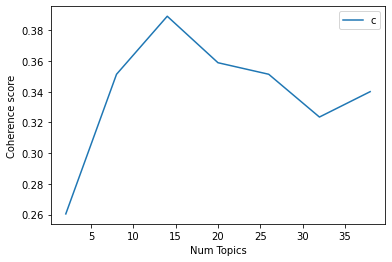

In [25]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [27]:
# Select the model and print the topics
optimal_model = ldamallet
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.124*"tired" + 0.056*"work" + 0.034*"back" + 0.026*"week" + 0.026*"feel" + '
  '0.018*"sleep" + 0.016*"today" + 0.016*"fuck" + 0.014*"run" + '
  '0.014*"fucking"'),
 (1,
  '0.015*"drug" + 0.013*"big" + 0.012*"health" + 0.012*"check" + 0.011*"issue" '
  '+ 0.010*"business" + 0.008*"woman" + 0.008*"problem" + 0.007*"group" + '
  '0.007*"fast"'),
 (2,
  '0.075*"people" + 0.054*"make" + 0.035*"thing" + 0.028*"feel" + 0.025*"life" '
  '+ 0.023*"emotion" + 0.020*"man" + 0.019*"bad" + 0.019*"stop" + '
  '0.016*"talk"'),
 (3,
  '0.047*"death" + 0.046*"covid" + 0.037*"vaccine" + 0.025*"case" + '
  '0.017*"country" + 0.016*"coronavirus" + 0.016*"test" + 0.015*"testing" + '
  '0.012*"high" + 0.011*"government"'),
 (4,
  '0.062*"dead" + 0.045*"stress" + 0.040*"mask" + 0.020*"face" + 0.017*"wait" '
  '+ 0.015*"put" + 0.013*"lol" + 0.011*"buy" + 0.011*"night" + 0.010*"body"'),
 (5,
  '0.050*"amp" + 0.037*"pandemic" + 0.024*"world" + 0.020*"live" + '
  '0.016*"crisis" + 0.015*"support" + 0.0

### Finding dominant topic in each sentence

In [30]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.1354,"fight, good, love, give, toxic, time, great, l...",best depression killer worshipping jesus try v...
1,1,6.0,0.1475,"time, home, year, hospital, lockdown, friend, ...",hope blessings majlis depression never return ...
2,2,5.0,0.1721,"amp, pandemic, world, live, crisis, support, c...",feels like theory psychohistory ing together h...
3,3,7.0,0.1545,"day, spread, quarantine, today, end, watch, ci...",post project depression cant believe days ende...
4,4,7.0,0.1133,"day, spread, quarantine, today, end, watch, ci...",depression thought
5,5,0.0,0.1296,"tired, work, back, week, feel, sleep, today, f...",sleepy time sleep depression go away pls
6,6,7.0,0.1325,"day, spread, quarantine, today, end, watch, ci...",rapper acid depression blazer
7,7,5.0,0.1389,"amp, pandemic, world, live, crisis, support, c...",single mother suffering depression asks cpf bo...
8,8,0.0,0.1639,"tired, work, back, week, feel, sleep, today, f...",tue dec nikerunning quick mins done dusted pac...
9,9,0.0,0.1380,"tired, work, back, week, feel, sleep, today, f...",tue dec nikerunning need get feel bad cos bad ...


In [32]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.3382,"tired, work, back, week, feel, sleep, today, f...",tired tired tired tired tired tired tired tire...
1,1.0,0.2985,"drug, big, health, check, issue, business, wom...",debarun roy choudhary united overseas bank tal...
2,2.0,0.2710,"people, make, thing, feel, life, emotion, man,...",point cringe wish make cringe thinking things ...
3,3.0,0.3253,"death, covid, vaccine, case, country, coronavi...",new graph illustrates extent ongoing tragedy i...
4,4.0,0.3179,"dead, stress, mask, face, wait, put, lol, buy,...",pink panther say stepped ant dead ant dead ant...
5,5.0,0.2770,"amp, pandemic, world, live, crisis, support, c...",valuable thread brand building times covid pls...
6,6.0,0.2889,"time, home, year, hospital, lockdown, friend, ...",sir sravanthi visakhapatnam weeks pregnant lad...
7,7.0,0.3286,"day, spread, quarantine, today, end, watch, ci...",added st photo fried rice pan fried leather ja...
8,8.0,0.3646,"find, call, zoom, start, free, learn, open, vi...",zoom calls equal productivity zoom calls equal...
9,9.0,0.2714,"fight, good, love, give, toxic, time, great, l...",arsenal fan toxic much passion fan club owner ...


In [36]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(20)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,9.0,"fight, good, love, give, toxic, time, great, l...",11309.0,0.1697
1.0,6.0,"time, home, year, hospital, lockdown, friend, ...",6294.0,0.0944
2.0,5.0,"amp, pandemic, world, live, crisis, support, c...",7115.0,0.1068
3.0,7.0,"day, spread, quarantine, today, end, watch, ci...",7087.0,0.1063
4.0,7.0,"day, spread, quarantine, today, end, watch, ci...",7314.0,0.1097
5.0,0.0,"tired, work, back, week, feel, sleep, today, f...",5445.0,0.0817
6.0,7.0,"day, spread, quarantine, today, end, watch, ci...",5736.0,0.0861
7.0,5.0,"amp, pandemic, world, live, crisis, support, c...",5833.0,0.0875
8.0,0.0,"tired, work, back, week, feel, sleep, today, f...",4771.0,0.0716
9.0,0.0,"tired, work, back, week, feel, sleep, today, f...",5746.0,0.0862
